### COURSE: Deep Learning ITE 5410 - RNN Model Comparitive Model- Time Series Prediction
### GROUP MEMBER NAMES: 
Chak Pu Patrick Tong N01631495

Christian Crawford N01235482

Parmjit Kanth N00088570
### Date: April 13, 2025

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch

# Set PyTorch print options for better numerical readability
torch.set_printoptions(precision=6)

# Load the raw CSV data for each index (monthly time-series data)
raw_data_A = pd.read_csv('data/data_A.csv')
raw_data_B = pd.read_csv('data/data_B.csv')
raw_data_C = pd.read_csv('data/data_C.csv')

# Extract only the numeric columns from each dataset (excluding 'date' or non-numeric fields)
data_A = raw_data_A.select_dtypes(include=[np.number])
data_B = raw_data_B.select_dtypes(include=[np.number])
data_C = raw_data_C.select_dtypes(include=[np.number])

# Initialize MinMaxScalers for each dataset to normalize values between 0 and 1
scaler_1 = MinMaxScaler()
scaler_2 = MinMaxScaler()
scaler_3 = MinMaxScaler()

# Define the split index for training and testing (80% training, 20% testing)
split_up_index = int(len(data_A) * 0.8)

# Fit scalers on training data and transform it
scaled_train_data_A = scaler_1.fit_transform(data_A[:split_up_index].values)
scaled_train_data_B = scaler_2.fit_transform(data_B[:split_up_index].values)
scaled_train_data_C = scaler_3.fit_transform(data_C[:split_up_index].values)

# Use the same scalers to transform test data (no fitting here)
scaled_test_data_A = scaler_1.transform(data_A[split_up_index:].values)
scaled_test_data_B = scaler_2.transform(data_B[split_up_index:].values)
scaled_test_data_C = scaler_3.transform(data_C[split_up_index:].values)


In [50]:
scaled_train_data_C[13:]

array([[0.        ],
       [0.03059766],
       [0.04546754],
       [0.03116957],
       [0.04175007],
       [0.04832714],
       [0.0303117 ],
       [0.02716614],
       [0.06376894],
       [0.25850729],
       [0.7718044 ],
       [0.01201029],
       [0.01744352],
       [0.06948813],
       [0.05890764],
       [0.04746926],
       [0.05204461],
       [0.0577638 ],
       [0.06434086],
       [0.06577066],
       [0.11752931],
       [0.31484129],
       [0.8204175 ],
       [0.03059766],
       [0.02545039],
       [0.07063197],
       [0.08321418],
       [0.07006005],
       [0.08492994],
       [0.07863883],
       [0.07720904],
       [0.07720904],
       [0.11924507],
       [0.35859308],
       [0.86931656],
       [0.03688876],
       [0.04603946],
       [0.08979125],
       [0.08178439],
       [0.02659422],
       [0.07806691],
       [0.08607378],
       [0.0852159 ],
       [0.08407206],
       [0.14812697],
       [0.4077781 ],
       [1.        ],
       [0.044

In [ ]:
# Function: create_sequences_torch
#   Creates padded time-series sequences from three datasets.
#   Each sequence is formed by stacking features from data_A, data_B, and data_C.
#   The target is the value from data_C one step ahead of the sequence end.

def create_sequences_torch(data_A, data_B, data_C, min_length=12):
    output_seq = []  # List to store input sequences
    target = []      # List to store corresponding target values

    for x in range(min_length, len(data_A) - 1):
        inner_seq = torch.tensor(np.column_stack((
            data_A[:x], 
            data_B[:x], 
            data_C[:x]
        )), dtype=torch.float)

        output_seq.append(inner_seq)
        target.append(data_C[x + 1])

    padded_seq = torch.nn.utils.rnn.pad_sequence(output_seq, batch_first=True, padding_value=0)
    return padded_seq, torch.tensor(target, dtype=torch.float32)

In [52]:
train_seq, train_targets = create_sequences_torch(scaled_train_data_A, scaled_train_data_B, scaled_train_data_C)
test_seq, test_targets = create_sequences_torch(scaled_test_data_A, scaled_test_data_B, scaled_test_data_C)

In [53]:
print(train_seq.shape)
print(train_targets.shape)

torch.Size([297, 308, 3])
torch.Size([297, 1])


In [ ]:
# Import tools for building datasets and dataloaders
from torch.utils.data import DataLoader, Dataset

# Compute actual sequence lengths (non-zero time steps)
def get_lengths(padded_sequences):
    mask = (padded_sequences.abs().sum(dim=2) > 0).int()
    lengths = mask.sum(dim=1)
    return lengths

# Custom dataset to return padded sequences, lengths, and labels
class PreprocessedDataset(Dataset):
    def __init__(self, padded_sequences, labels):
        self.padded_sequences = padded_sequences
        self.labels = labels
        self.lengths = get_lengths(padded_sequences)

    def __len__(self):
        return len(self.padded_sequences)

    def __getitem__(self, idx):
        return self.padded_sequences[idx], self.lengths[idx], self.labels[idx]

# Custom collation: sort sequences by length for RNN efficiency
def collate_fn(batch):
    sequences, lengths, labels = zip(*batch)

    sequences = torch.stack(sequences)
    lengths = torch.tensor(lengths)
    labels = torch.tensor(labels)

    lengths, sort_idx = lengths.sort(descending=True)
    sorted_sequences = sequences[sort_idx]
    sorted_labels = labels[sort_idx]

    _, original_order = sort_idx.sort()

    return sorted_sequences, lengths, sorted_labels, original_order

# Create train and test datasets
train_set = PreprocessedDataset(train_seq, train_targets)
test_set = PreprocessedDataset(test_seq, test_targets)

# Dataloaders with batching and custom collation
train_loader = DataLoader(train_set, 
                        batch_size=64, 
                        shuffle=False,
                        collate_fn=collate_fn)

test_loader = DataLoader(test_set, 
                       batch_size=64, 
                       shuffle=False,
                       collate_fn=collate_fn)


In [ ]:
# Iterate over one batch to inspect shapes
# Useful for verifying data loader output before training
for batch in train_loader:
    sequences, lengths, labels, _ = batch
    print(f"Batch shapes - Sequences: {sequences.shape}, Labels: {labels.shape}")
    break

Batch shapes - Sequences: torch.Size([64, 308, 3]), Labels: torch.Size([64])


In [ ]:
# ---------------------------------------------------------
# STEP 2: MODEL DESIGN (LSTM)
# ---------------------------------------------------------

import torch.nn as nn

# RNN-based model for time series regression
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        fc_input_size = hidden_size
        self.rnn = nn.RNN(input_size, 
                          hidden_size, 
                          num_layers, 
                          batch_first=True,
                          dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(fc_input_size, 1)

    # Forward pass: input is padded sequences with lengths
    def forward(self, x, lengths, original_order=None):

        lengths = lengths.cpu()

        packed_input = nn.utils.rnn.pack_padded_sequence(
            x, 
            lengths, 
            batch_first=True, 
            enforce_sorted=True
        )

        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        packed_out, hn = self.rnn(packed_input, h0)

        out, _ = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True)

        out = self.dropout(out)

        last_seq_idxs = lengths - 1
        out = out[torch.arange(out.shape[0]), last_seq_idxs]

        if original_order is not None:
            out = out[original_order]

        out = self.fc(out)
        return out.squeeze(1)


In [ ]:
# ---------------------------------------------------------
# STEP 3: DEFINE TRAINING and EVALUTATION
# ---------------------------------------------------------

# Setup model config, loss, and optimizer
from enum import Enum
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Model and training configuration
input_size = 3 
hidden_size = 256
num_layers = 3
dropout = 0.4
learning_rate = 0.001
num_epochs = 500

# Initialize model and move to device
model = RNNModel(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    dropout=dropout
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Training loop
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    model.train()
    train_losses = []
    test_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        total_samples = 0
        
        for batch_idx, (sorted_sequences, lengths, sorted_labels, original_order) in enumerate(train_loader):
            sequences = sorted_sequences.to(device)
            labels = sorted_labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(sequences, lengths)
            loss = criterion(outputs.view(-1), labels.view(-1).float())
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * sequences.size(0)
            total_samples += sequences.size(0)
        
        epoch_train_loss = running_loss / total_samples
        train_losses.append(epoch_train_loss)
        
        model.eval()
        test_loss = 0.0
        total_test_samples = 0
        
        with torch.no_grad():
            for sequences, lengths, targets, _ in test_loader:
                sequences = sequences.to(device)
                targets = targets.to(device)
                
                outputs = model(sequences, lengths)
                loss = criterion(outputs.view(-1), targets.view(-1).float())
                
                test_loss += loss.item() * sequences.size(0)
                total_test_samples += sequences.size(0)
        
        epoch_test_loss = test_loss / total_test_samples
        test_losses.append(epoch_test_loss)
        
        if (epoch+1)%50 == 0:
            print(f"Epoch: {epoch+1}/{num_epochs} | "
              f"Train Loss: {epoch_train_loss:.4f} | "
              f"Test Loss: {epoch_test_loss:.4f}")
    
    return train_losses, test_losses

# Enum to label training or testing phase
class Case(Enum):
    test = "Test"
    train = "Train"

# Evaluation function to print loss and metrics
def evaluate_model(model, test_loader, criterion, case):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for sequences, seq_lengths, targets, _ in test_loader: 
            sequences = sequences.to(device)
            targets = targets.to(device)
            
            outputs = model(sequences, seq_lengths)
            loss = criterion(outputs.view(-1), targets.view(-1).float())
            total_loss += loss.item()
            
            preds = outputs.cpu().numpy()
            targets_np = targets.cpu().numpy()
   
            all_preds.extend(preds.flatten())
            all_targets.extend(targets_np.flatten())

    avg_loss = total_loss / len(test_loader)
    mse = mean_squared_error(all_targets, all_preds)
    mae = mean_absolute_error(all_targets, all_preds)
    r2 = r2_score(all_targets, all_preds)
    
    print(f'{case.value} Loss: {avg_loss:.4f} | MSE: {mse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}')
    return all_preds, all_targets

# Plot training and test loss curves
def plot_loss_curves(train_losses, test_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title('Training and Test Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
# Plot predicted vs actual target values
def plot_result(predictions, targets, title='Train vs Actual'):
    plt.figure(figsize=(12, 6))
    
    idx = np.arange(len(targets))
    
    plt.plot(idx, targets, label='Actual Values', alpha=0.7)
    plt.plot(idx, predictions, label='Predicted Values', alpha=0.5)
    
    plt.title(f'{title}')
    plt.xlabel('Sequence Index')
    plt.ylabel('Target Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Epoch: 50/500 | Train Loss: 0.0035 | Test Loss: 0.0115
Epoch: 100/500 | Train Loss: 0.0043 | Test Loss: 0.0157
Epoch: 150/500 | Train Loss: 0.0029 | Test Loss: 0.0098
Epoch: 200/500 | Train Loss: 0.0023 | Test Loss: 0.0114
Epoch: 250/500 | Train Loss: 0.0018 | Test Loss: 0.0103
Epoch: 300/500 | Train Loss: 0.0017 | Test Loss: 0.0093
Epoch: 350/500 | Train Loss: 0.0018 | Test Loss: 0.0109
Epoch: 400/500 | Train Loss: 0.0015 | Test Loss: 0.0128
Epoch: 450/500 | Train Loss: 0.0012 | Test Loss: 0.0155
Epoch: 500/500 | Train Loss: 0.0015 | Test Loss: 0.0185


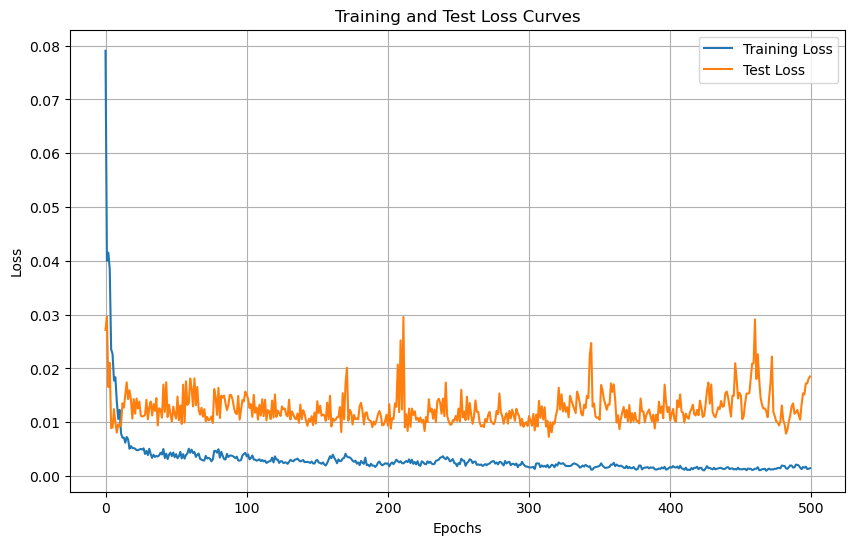

Train Loss: 0.0012 | MSE: 0.0013 | MAE: 0.0236 | R²: 0.9689
Test Loss: 0.0094 | MSE: 0.0185 | MAE: 0.1040 | R²: 0.0471


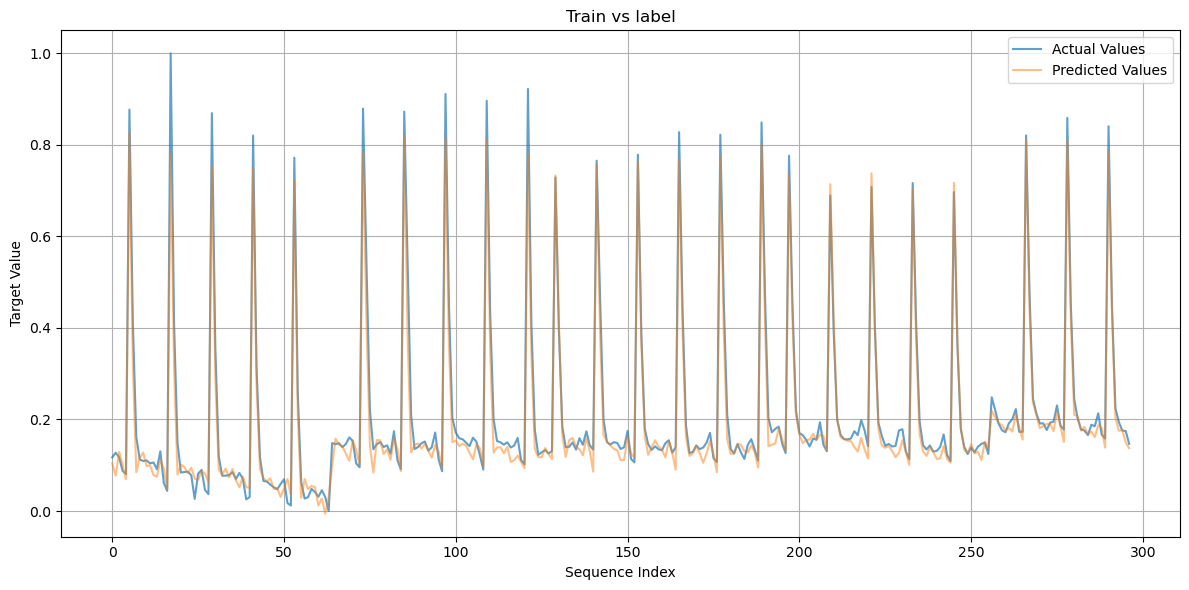

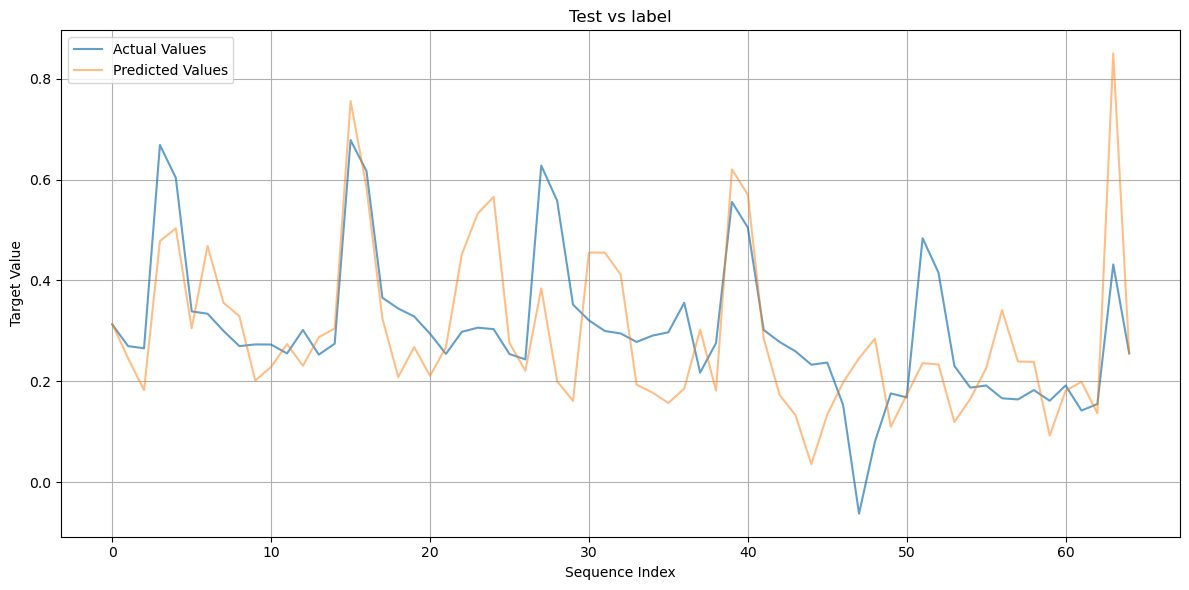

In [ ]:
# ---------------------------------------------------------
# STEP 4: EXECUTE, EVALUATE, and PLOT RESULTS
# ---------------------------------------------------------

from torch import optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
train_losses,test_losses = train_model(model, train_loader,test_loader, criterion, optimizer, num_epochs)

plot_loss_curves(train_losses,test_losses)

# Evaluate the model
train_preds, train_targets = evaluate_model(model, train_loader, criterion, Case.train)
test_pred, actual_Label = evaluate_model(model, test_loader, criterion, Case.test)

# Plot results
plot_result(train_preds,train_targets, title="Train vs label")
plot_result(test_pred, actual_Label, title="Test vs label")